In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/contradictory-my-dear-watson/sample_submission.csv
/kaggle/input/contradictory-my-dear-watson/train.csv
/kaggle/input/contradictory-my-dear-watson/test.csv


In [14]:
train = pd.read_csv("../input/contradictory-my-dear-watson/train.csv")
test = pd.read_csv("../input/contradictory-my-dear-watson/test.csv")

train.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


Explore data & drop any incomplete rows of data.

Find how many data points and features are in the original, provided training dataset.

In [15]:
# print out stats about data
missing_values_count = train.isnull().sum() # we get the number of missing data points per column
print("Number of missing data points per column:\n")
print (missing_values_count)

Number of missing data points per column:

id            0
premise       0
hypothesis    0
lang_abv      0
language      0
label         0
dtype: int64


In [16]:
# check the number of rows and columns in the training and test set
print("Training data info: {}".format(train.shape))
print("Test data info: {}".format(test.shape))

Training data info: (12120, 6)
Test data info: (5195, 5)


Let's look at the distribution of languages in the training and test sets.

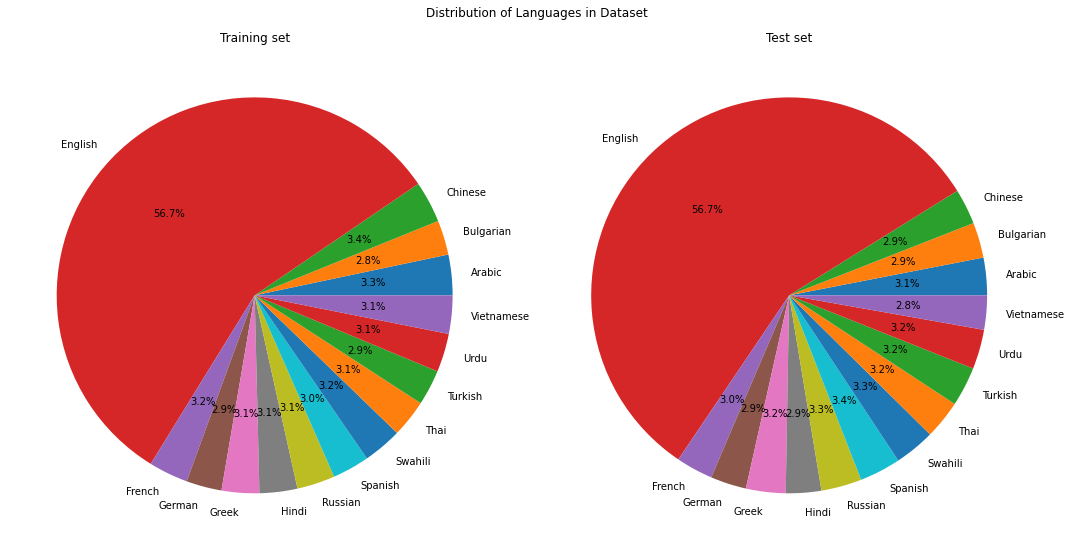

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8), tight_layout=True)
fig.suptitle('Distribution of Languages in Dataset')

labels, frequencies = np.unique(train.language.values, return_counts=True)
ax1.pie(frequencies, labels=labels, autopct='%1.1f%%')
ax1.set_title('Training set')

labels, frequencies = np.unique(test.language.values, return_counts=True)
ax2.pie(frequencies, labels=labels, autopct='%1.1f%%')
ax2.set_title('Test set')

# Save the full figure
fig.savefig('lang_dist.png')

As expected, more than half of the training and test examples are in English as data resources are abundant in this language. Rest of the data is fairly shared between other fourteen languages. 

Let's now visualize the distribution of class labels over the training data

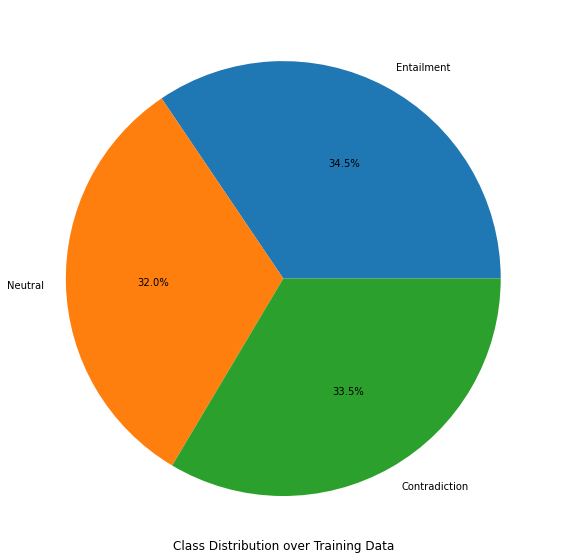

In [18]:
# counts for all classes
counts = train['label'].value_counts()

class_labels = ['Entailment', 'Neutral', 'Contradiction']

counts_per_class = [counts[0], counts[1], counts[2]]

# counts.plot(kind='barh')

plt.figure(figsize = (10,10))
plt.pie(counts_per_class,labels = class_labels, autopct = '%1.1f%%')
plt.title('Class Distribution over Training Data', y=-0.01)
plt.savefig('class.png')
plt.show()

We also plot the class distribution per language.

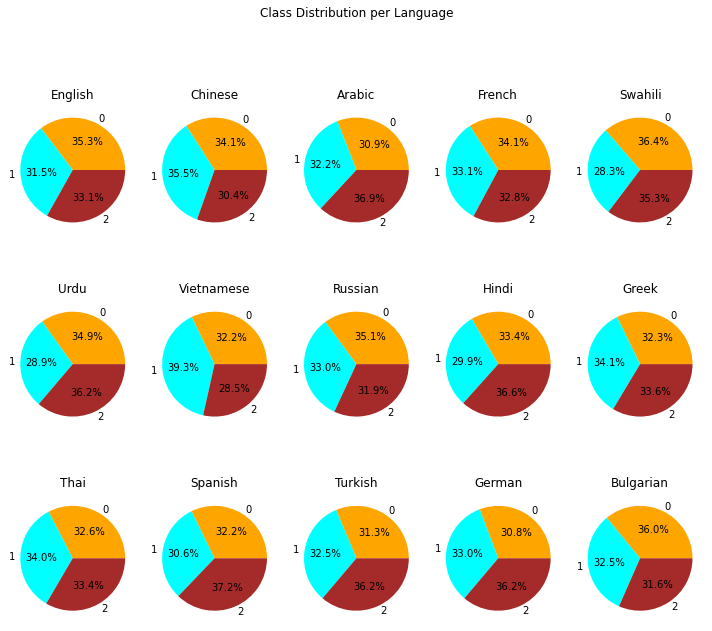

In [19]:
#plot class distribution per language
lang_count_train = train['language'].value_counts(sort=True)
lang_list = list(lang_count_train.index)

fig,axes = plt.subplots(nrows=3, ncols=5, figsize=(10,10), tight_layout=True)
fig.suptitle('Class Distribution per Language')
n_rows = 3
index = 0
colors = ("orange", "cyan", "brown")
for i in range(n_rows):
    n_cols = 5
    for j in range(n_cols):
        lang = lang_list[index]
        label_count = train[train.language == lang]['label'].value_counts(sort=False) #do not sort the class values, the order will always be class 0, 1, 2
        labels, frequencies = label_count.index, label_count.values
        axes[i, j].pie(frequencies, labels=labels, autopct='%1.1f%%', colors=colors)
        axes[i, j].set_title(lang)
        index += 1
        
# Save the full figure
fig.savefig('class_per_lang.png')

We can see that the overall training set contains close to equal number of examples per class, while the distribution of the training labels is also quite balanced in all the languages.


Plot the word length distribution (e.g. number of word tokens in an input text, split by the whitespace delimiter) on the training data.

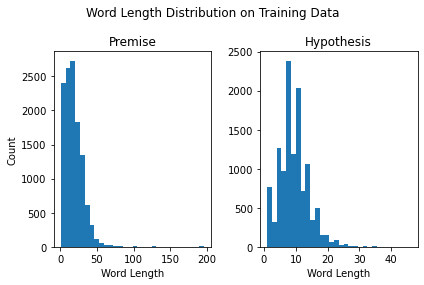

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True)
fig.suptitle('Word Length Distribution on Training Data')

train['premise_word_length'] = [len(text.split()) for text in train['premise']]
ax1.hist(train['premise_word_length'], bins=30)
ax1.set_title('Premise')
ax1.set(xlabel='Word Length', ylabel='Count')

train['hypothesis_word_length'] = [len(text.split()) for text in train['hypothesis']]
ax2.hist(train['hypothesis_word_length'], bins=30)
ax2.set_title('Hypothesis')
ax2.set(xlabel='Word Length')

# Save the full figure
fig.savefig('word_length_dist_train.png')

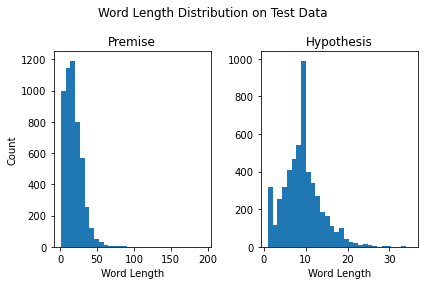

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True)
fig.suptitle('Word Length Distribution on Test Data')

test['premise_word_length'] = [len(text.split()) for text in test['premise']]
ax1.hist(test['premise_word_length'], bins=30)
ax1.set_title('Premise')
ax1.set(xlabel='Word Length', ylabel='Count')

test['hypothesis_word_length'] = [len(text.split()) for text in test['hypothesis']]
ax2.hist(test['hypothesis_word_length'], bins=30)
ax2.set_title('Hypothesis')
ax2.set(xlabel='Word Length')

# Save the full figure
fig.savefig('word_length_dist_test.png')

We can see from the above figures that for both the datasets, the lengths of the premise sentences are greater than those of the hypothesis sentences.

Calculate the max and mean sequence length per language on the training data.

In [22]:
# Calculate max and avg sequence length per language
info_per_lang_train = train.groupby('language').agg({'premise_word_length': ['mean', 'max', 'count'], 'hypothesis_word_length': ['mean', 'max', 'count']})
print (info_per_lang_train)
print()

           premise_word_length            hypothesis_word_length          
                          mean  max count                   mean max count
language                                                                  
Arabic               16.147132   40   401               7.837905  28   401
Bulgarian            17.891813   39   342               8.976608  31   342
Chinese               1.279805   13   411               1.080292   5   411
English              19.314119  196  6870               9.938865  46  6870
French               19.787179   44   390              10.343590  25   390
German               17.433048   41   351               8.960114  24   351
Greek                18.793011   44   372               9.258065  23   372
Hindi                21.131016   47   374              11.016043  28   374
Russian              16.279255   40   376               8.114362  23   376
Spanish              19.642077   44   366               9.863388  34   366
Swahili              16.1

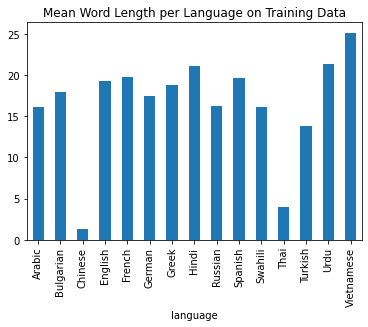

In [23]:
column_name_train = info_per_lang_train.columns.values[0] #premise mean column
info_per_lang_train[column_name_train].plot(kind='bar')
plt.title('Mean Word Length per Language on Training Data')
plt.savefig('mean_dist_train.png')